## Vessel motion calculation

In this notebook we estimate the motion of a 95 m platform supply vessel in a given wave field. The wave field is directly extracted from datamesh in the shape of a timeseries of two-dimensional SWAN spectra. The motion of the vessel is calculated by convolving the wave spectra with the response amplitude operator (RAO) of the vessel.

# Response amplitude operator

The response amplitude operator is a series of two-dimensional tables which describe the response of the vessel over a range of discrete (wave frequency x wave direction with respect to the vessel) bins. Tables contains the magnitude and the phase of the vessel response for each degree of freedom of the vessel (surge, sway, heave, roll, pitch and yaw).

The RAO were produced by a software called WAMIT and the first step is to read the WAMIT output files and put them in a format that is practical for calculation of the vessel motion. For that purpose we use the python libraries numpy and XArray. With numpy we read the raw data and manipulate the initial arrays. With xarray we bundle all the data in a dataset which will be used for the calculations. 

In [1]:
# Import the necessary libraries
import numpy as np
from matplotlib import pyplot as plt # For plotting
import xarray as xr

# Read the raw WAMIT output file
raw_data = np.loadtxt('./Psv01/wamit.4')
raw_data

array([[ 7.500000e-02,  0.000000e+00,  1.000000e+00, ..., -9.009114e+01,
        -1.119934e-02, -7.040557e+00],
       [ 7.500000e-02,  0.000000e+00,  2.000000e+00, ...,  9.000000e+01,
         0.000000e+00,  0.000000e+00],
       [ 7.500000e-02,  0.000000e+00,  3.000000e+00, ..., -2.747055e-03,
         9.966681e-01, -4.778541e-05],
       ...,
       [ 1.400000e+00,  3.600000e+02,  4.000000e+00, ...,  1.701879e+02,
        -8.729749e-08,  1.509797e-08],
       [ 1.400000e+00,  3.600000e+02,  5.000000e+00, ..., -1.426044e+01,
         4.677530e-01, -1.188848e-01],
       [ 1.400000e+00,  3.600000e+02,  6.000000e+00, ...,  1.030612e+02,
        -1.525465e-08,  6.575438e-08]])

In [2]:
# Extract the frequency, direction and degrees of freedom tables
freqs = np.unique(raw_data[:,0])/(2*np.pi) # in rad/s -> Hz (same as wave spectrum)
dirs = np.unique(raw_data[:,1]) # in degrees
dofs = np.array(['surge', 'sway', 'heave', 'roll', 'pitch', 'yaw'])

The WAMIT outputs are non-dimensionalized, so we need to convert them to SI units. According to the WAMIT documentation, the RAO magnitudes normalisation was done by applying a $\frac{1}{(A/L^n)}$ factor where A is the reference wave amplitude, L a reference length-scale and n is 0 for surge/sway/heave and 1 for roll/pitch/yaw. We also convert roll, pitch and yaw tables from radians to degrees.

In [3]:
# Extract some specific data for the WAMIT documentation.
# This is required as the WAMIT output are non-dimensionalized
L = ULEN = 100
A = 1 # Incident wave amplitude

# RAO magnitudes are non dimentionalize by (A/L^n) where A is the amplitude of the wave, L is the length of the body and n is 0 for i = 1,2,3 and 1 for i = 4,5,6 (rotational motions in rad)
factor = np.array([(A/L**0) for i in range(3)] + [(180/np.pi)*(A/L**1) for i in range(3)])
factor

array([1.       , 1.       , 1.       , 0.5729578, 0.5729578, 0.5729578])

In [4]:
# Split the RAO tables into amplitude and phase and imaginary and real parts
# + apply the scalingfactor
data = raw_data.reshape((freqs.size, dirs.size, dofs.size, -1))[:,:,:,3:]
amplitude = data[:,:,:,0]*factor
phase = data[:,:,:,1]
real = data[:,:,:,2]*factor
imag = data[:,:,:,3]*factor

In [5]:
# Packaging of the RAO data into an xarray dataset
rao = xr.Dataset(coords={
                        'freq': freqs,
                        'dir': dirs,
                        'dof': dofs
                 },
                 data_vars={
                    'magnitude': (['freq', 'dir', 'dof'], amplitude),
                    'phase': (['freq', 'dir', 'dof'], phase),
                    'RAO': (['freq', 'dir', 'dof'], real + 1j*imag)
                 }
                )
rao

<xarray.Dataset> Size: 260kB
Dimensions:    (freq: 54, dir: 25, dof: 6)
Coordinates:
  * freq       (freq) float64 432B 0.01194 0.01592 0.01989 ... 0.2188 0.2228
  * dir        (dir) float64 200B 0.0 15.0 30.0 45.0 ... 315.0 330.0 345.0 360.0
  * dof        (dof) <U5 120B 'surge' 'sway' 'heave' 'roll' 'pitch' 'yaw'
Data variables:
    magnitude  (freq, dir, dof) float64 65kB 7.041 0.0 ... 0.2765 3.868e-08
    phase      (freq, dir, dof) float64 65kB -90.09 90.0 ... -14.26 103.1
    RAO        (freq, dir, dof) complex128 130kB (-0.01119934-7.040557j) ... ...

Now that the RAO data is in a xarray dataset, we can easily plot the RAO magnitude and phase for each degree of freedom and check that the data looks as expected.This seems to be the case for all degrees of freedom except for the roll which seems large.

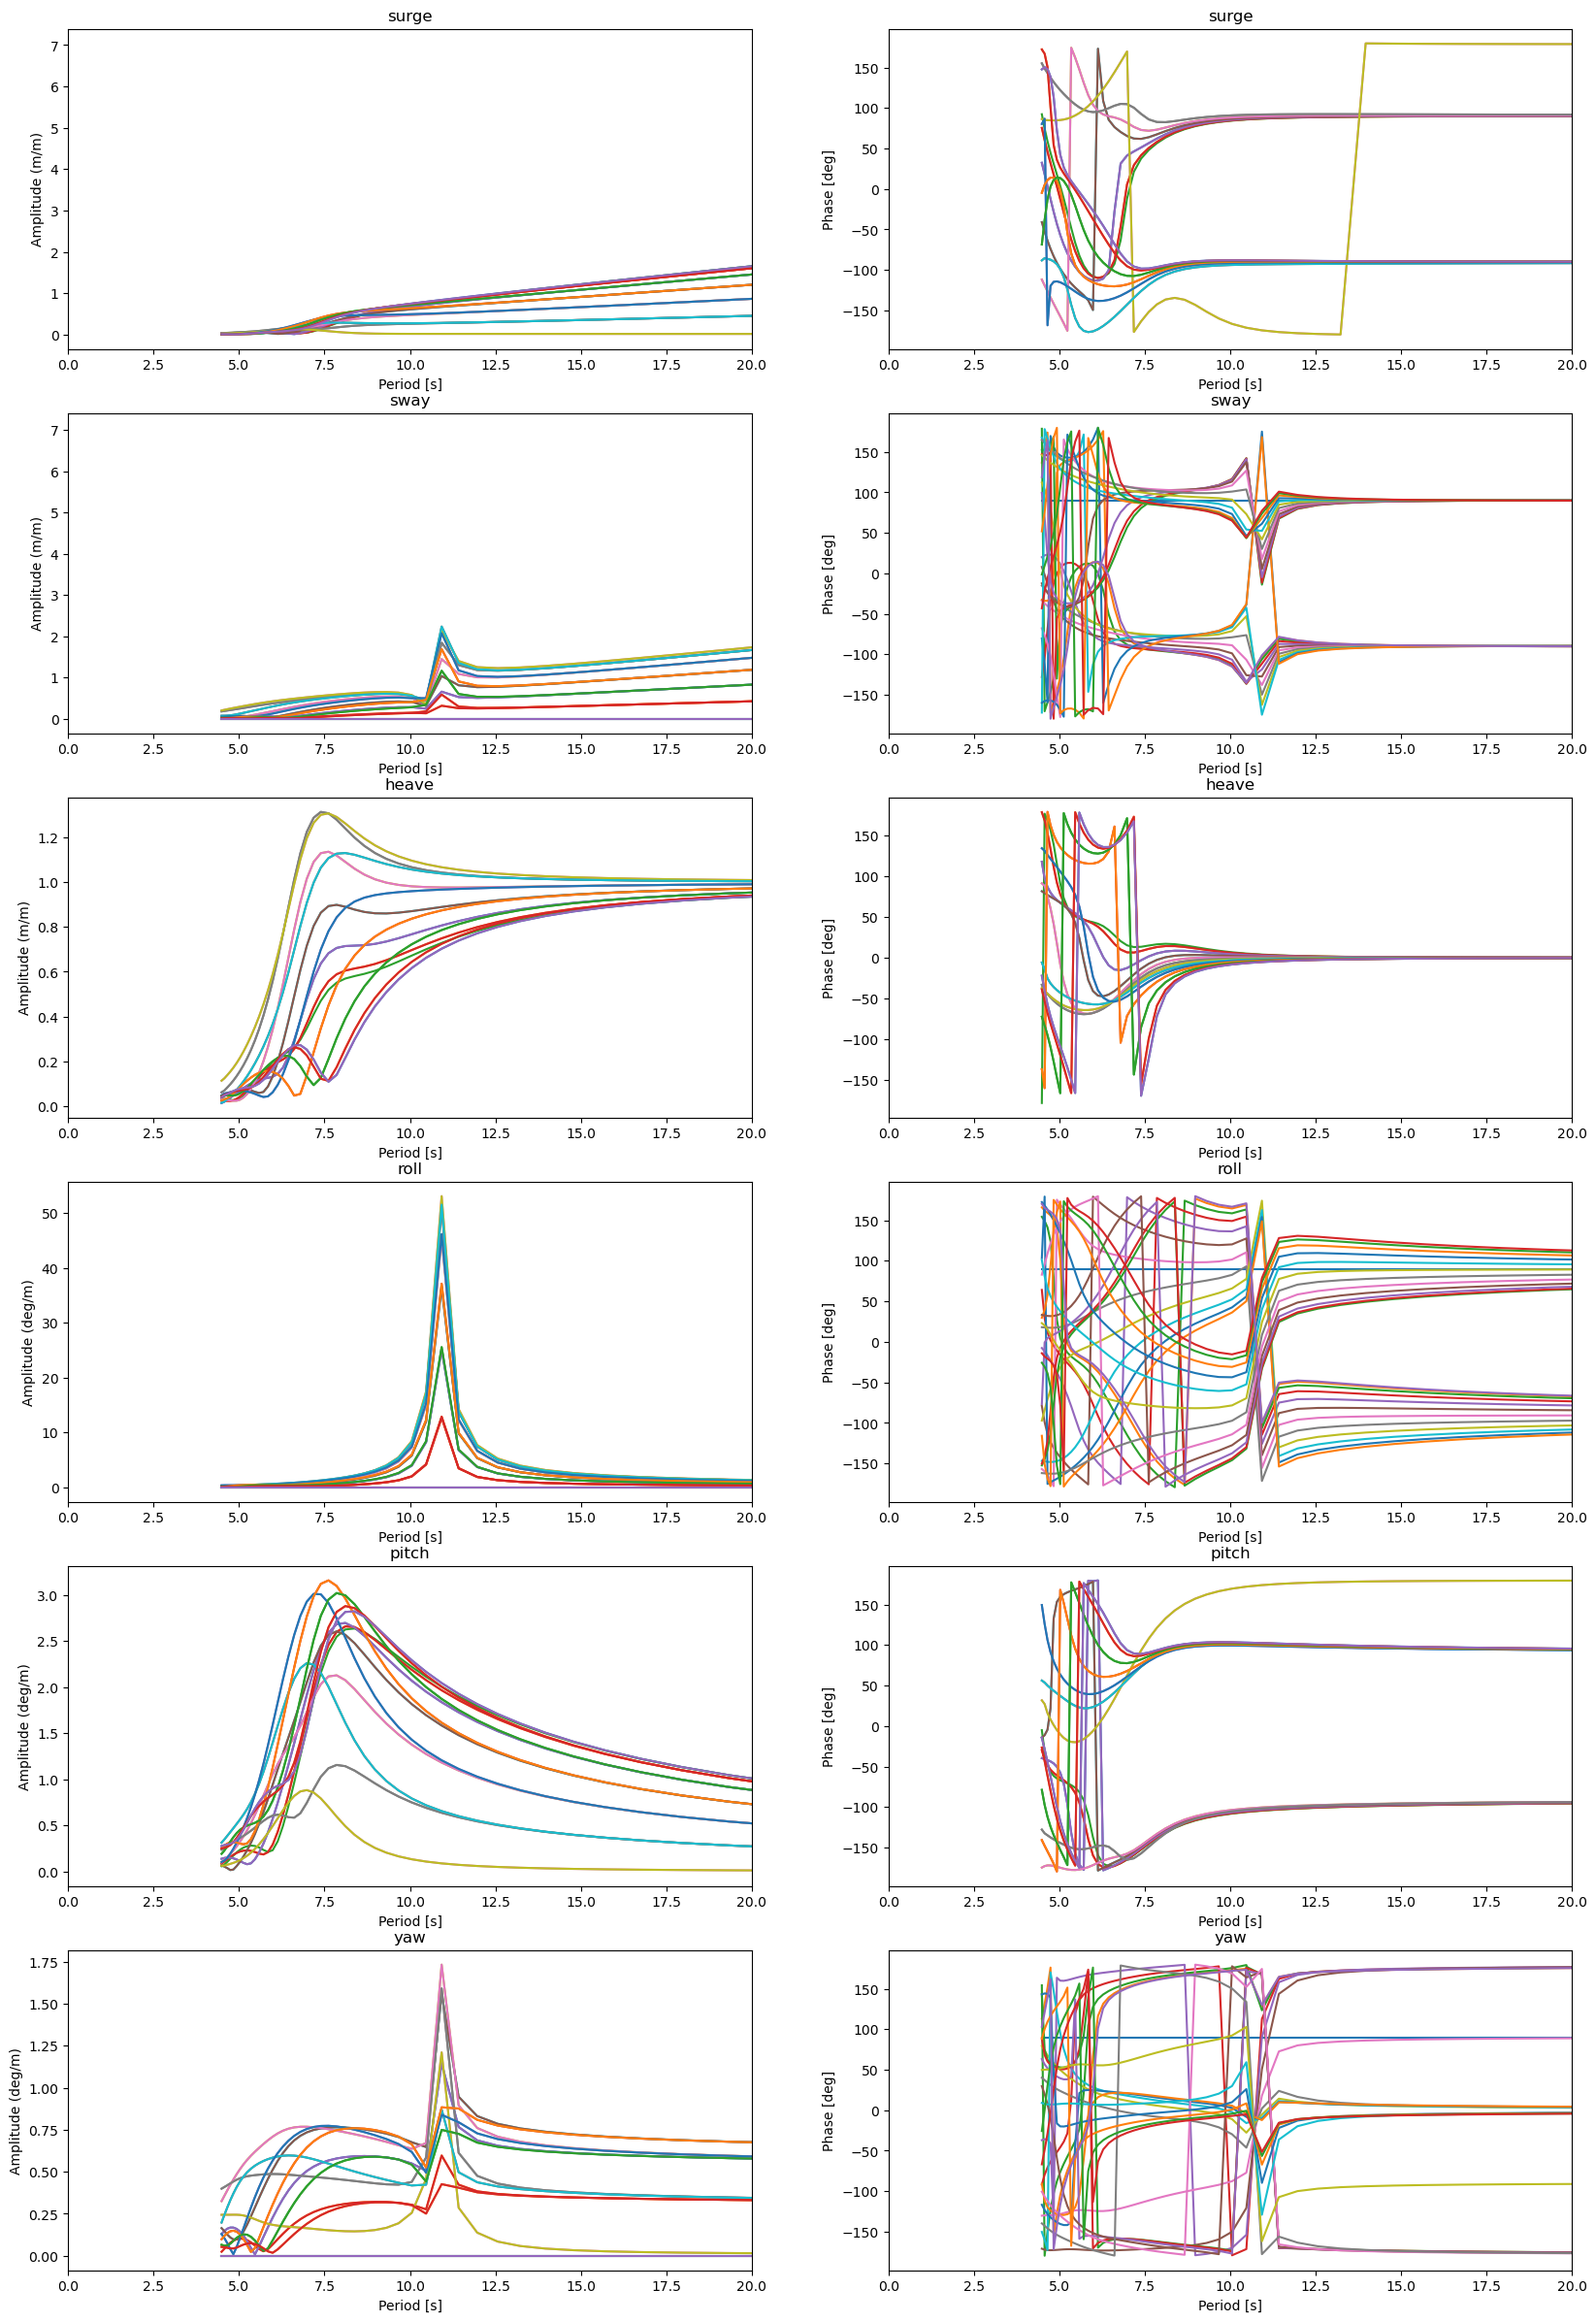

In [100]:
fig, ax = plt.subplots(ncols=2, nrows=6, figsize=(20,30))
for idof, dof in enumerate(dofs):
    for idir, dir in enumerate(dirs):
        selected = rao.sel(dof=dof, dir=dir)
        ax[idof,0].plot(1/rao.freq, selected.magnitude)
        ax[idof,1].plot(1/rao.freq, selected.phase)
        ax[idof,0].set_title(dof)
        ax[idof,1].set_title(dof)
        ax[idof,0].set_xlabel('Period [s]')
        ax[idof,1].set_xlabel('Period [s]')
        if idof < 3:
            ax[idof,0].set_ylabel('Amplitude (m/m)')
        else:
            ax[idof,0].set_ylabel('Amplitude (deg/m)')
        ax[idof,1].set_ylabel('Phase [deg]')
        ax[idof,0].set_xlim([0, 20])
        ax[idof,1].set_xlim([0, 20])

# Wave data

For the purpose of this demonstration, we use wave data from Oceanum's Western Europse SWAN forecast. We start by instantiating the datamesh connector and add our datamesh token. Then we find the datasource.

In [7]:
import os, dotenv
from oceanum.datamesh import Connector
import wavespectra

datamesh = Connector()

In [8]:
datamesh.get_datasource('oceanum_wave_gfs_weuro_spec')


        Oceanum Western Europe GFS wave forecast spectra [oceanum_wave_gfs_weuro_spec]
            Extent: (-10.800000190734863, 48.599998474121094, 12.799999237060547, 60.900001525878906)
            Timerange: 2024-04-29 12:00:00+00:00 to 2024-04-29 23:26:52.197850+00:00
            8 attributes
            6 variables
        

A lazy loading of the data shows that the forecast is available for the next 7 days at 5044 different locations. The resolution of each of the spectra is 36 directional bins x 32 frequency bins.

In [9]:
ds = datamesh.load_datasource('oceanum_wave_gfs_weuro_spec')
ds

<xarray.Dataset> Size: 4GB
Dimensions:  (dir: 36, time: 169, site: 5044, freq: 32)
Coordinates:
  * dir      (dir) float32 144B 265.0 255.0 245.0 235.0 ... 295.0 285.0 275.0
  * freq     (freq) float32 128B 0.037 0.0407 0.04477 ... 0.5869 0.6456 0.7102
  * site     (site) int64 40kB 1 2 3 4 5 6 7 ... 5039 5040 5041 5042 5043 5044
  * time     (time) datetime64[ns] 1kB 2024-12-01T12:00:00 ... 2024-12-08T12:...
Data variables:
    dpt      (time, site) float32 3MB dask.array<chunksize=(169, 4), meta=np.ndarray>
    efth     (time, site, freq, dir) float32 4GB dask.array<chunksize=(169, 4, 32, 36), meta=np.ndarray>
    lat      (site) float32 20kB dask.array<chunksize=(5044,), meta=np.ndarray>
    lon      (site) float32 20kB dask.array<chunksize=(5044,), meta=np.ndarray>
    wdir     (time, site) float32 3MB dask.array<chunksize=(169, 4), meta=np.ndarray>
    wspd     (time, site) float32 3MB dask.array<chunksize=(169, 4), meta=np.ndarray>

We only need data for a single site, we choose a site and load the data. For practical reasons we store the data on drive.

In [68]:
ds.isel(site=5000).to_netcdf('/data/swan_forecast_5000.nc')

We reload the data using the wavespectra library. Wavespectra is an extension of xarray that implements a number of functions and algorithms specific to wave data that will be useful here.

In [93]:
import wavespectra
wave_data = wavespectra.read_netcdf('/data/swan_forecast_5000.nc')
wave_data

<xarray.Dataset> Size: 782kB
Dimensions:  (dir: 36, time: 169, freq: 32)
Coordinates:
  * dir      (dir) float32 144B 265.0 255.0 245.0 235.0 ... 295.0 285.0 275.0
  * freq     (freq) float32 128B 0.037 0.0407 0.04477 ... 0.5869 0.6456 0.7102
    site     int64 8B ...
  * time     (time) datetime64[ns] 1kB 2024-12-01T12:00:00 ... 2024-12-08T12:...
Data variables:
    dpt      (time) float32 676B dask.array<chunksize=(169,), meta=np.ndarray>
    efth     (time, freq, dir) float32 779kB dask.array<chunksize=(169, 32, 36), meta=np.ndarray>
    lat      float32 4B ...
    lon      float32 4B ...
    wdir     (time) float32 676B dask.array<chunksize=(169,), meta=np.ndarray>
    wspd     (time) float32 676B dask.array<chunksize=(169,), meta=np.ndarray>

The plot below illustrates the range of periods covered by the RAO and the wave spectra. The RAO extend all the way to period of 80 seconds when the spectra only goes up to 27 seconds. Conversely the spectra extends to small periods of the order the 1.5 seconds when the RAO starts around 4.5 s where the response of the vessel to the waves is small.

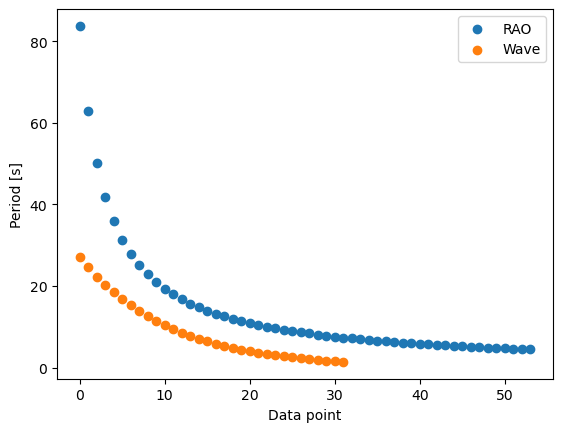

In [70]:
plt.scatter(range(rao.freq.size), 1/rao.freq, label='RAO')
plt.scatter(range(wave_data.freq.size), 1/wave_data.freq, label='Wave')
plt.ylabel('Period [s]')
plt.xlabel('Data point')
plt.legend()

Below is a plot of the wave significant height, peak period and peak direction. Signigicant wave height is almost always below 2 meters with a peak of 3 meters. The peak period also varies a little over the 7.5 days period but remains always below 7s.

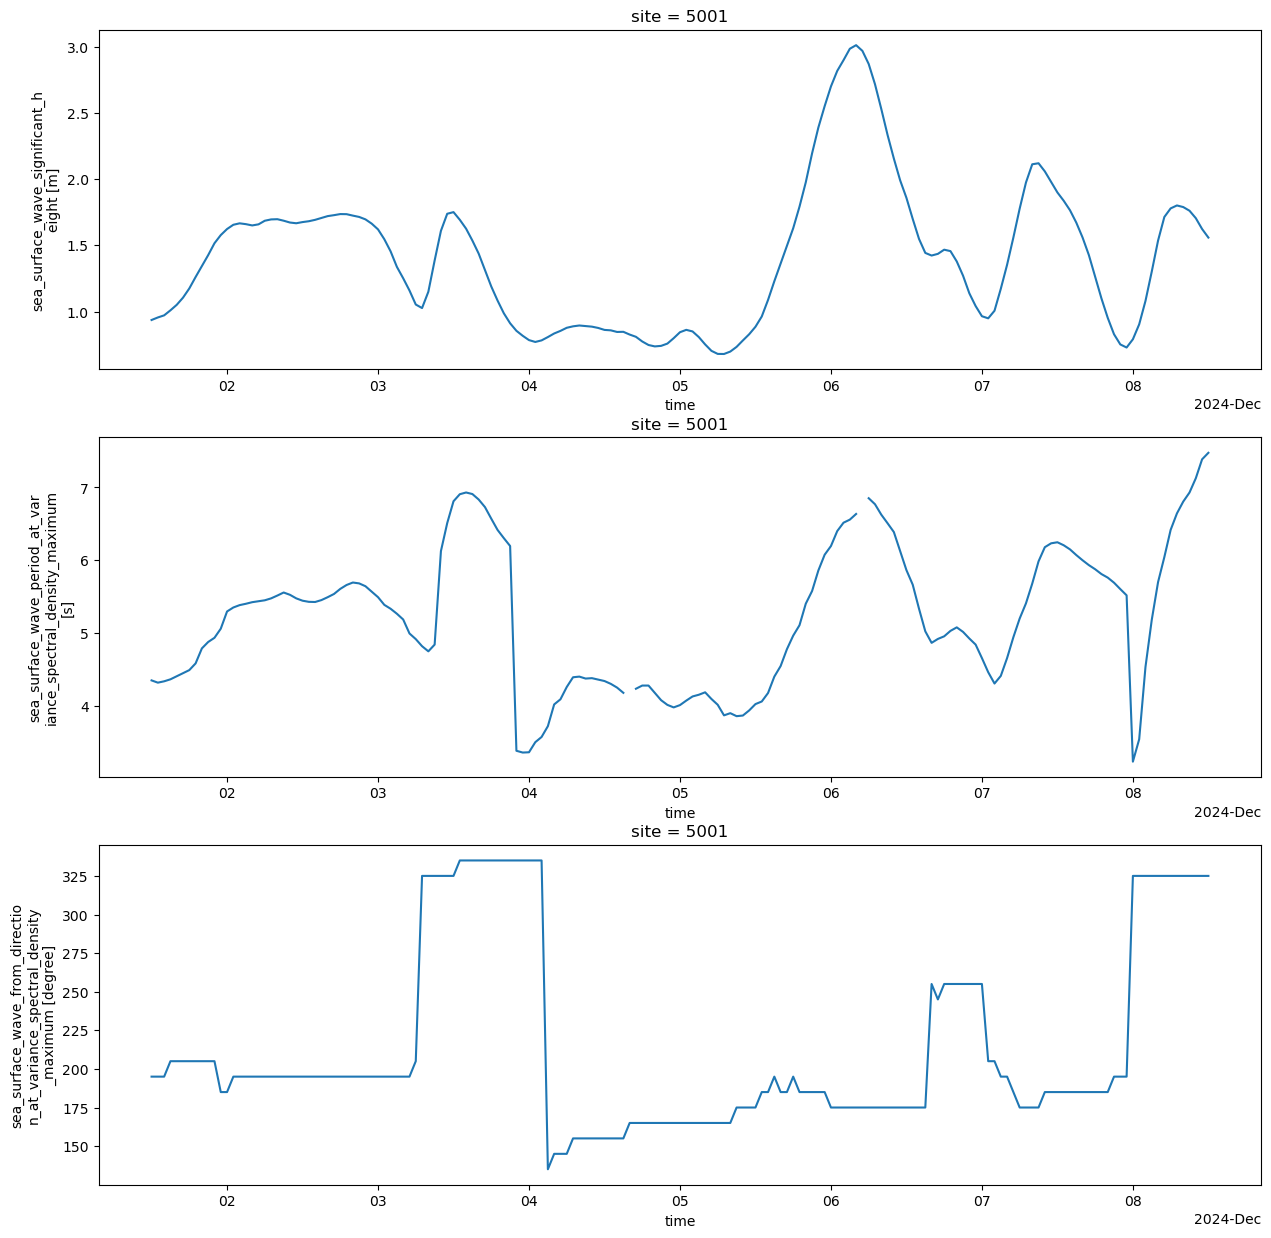

In [94]:
fig, ax = plt.subplots(figsize=(15,15), ncols=1, nrows=3)
wave_data.spec.hs().plot(ax=ax[0])
wave_data.spec.tp().plot(ax=ax[1])
wave_data.spec.dp().plot(ax=ax[2])

To caculate the vessel response to the wave field, we need to align the wave spectra and the RAO. We will do that by interpolating the RAO on the wave frequencies and directions. We first rotate the RAOs to account for the heading of the vessel, then interpolate the RAO onto the frequency/direction grid of the spectra. Before the wave spectra are in the energy space, we square the RAO before convolving them. Finally, we get the significant motion using the same formula as that normally used to caculate the significant wave height (already implemented in wavespectra).

Instead of making up a time series of headings, we assume here at first that spectra and RAO are already aligned then we inspose a 90 degree rotation.

In [95]:
heading_rotation = 0
ship_motion0 =\
    (np.square(rao.magnitude.interp(freq=wave_data.freq,
                                    dir=(wave_data.dir+heading_rotation)%360).fillna(0.))*wave_data.efth).spec.hs()

In [96]:
heading_rotation = 90
ship_motion90 =\
    (np.square(rao.magnitude.interp(freq=wave_data.freq,
                                    dir=(wave_data.dir+heading_rotation)%360).fillna(0.))*wave_data.efth).spec.hs()

The heave response follows quite closely the significant wave height curves with the response being lower when the wave period is smaller, as expected. The pitch and roll reponses favour the peaks in significant wave height for which the period is the largest reflecting the response amplitude operators. When rotating the vessel by 90 degrees, the response in roll almost doubles when that in pitch decreases. 

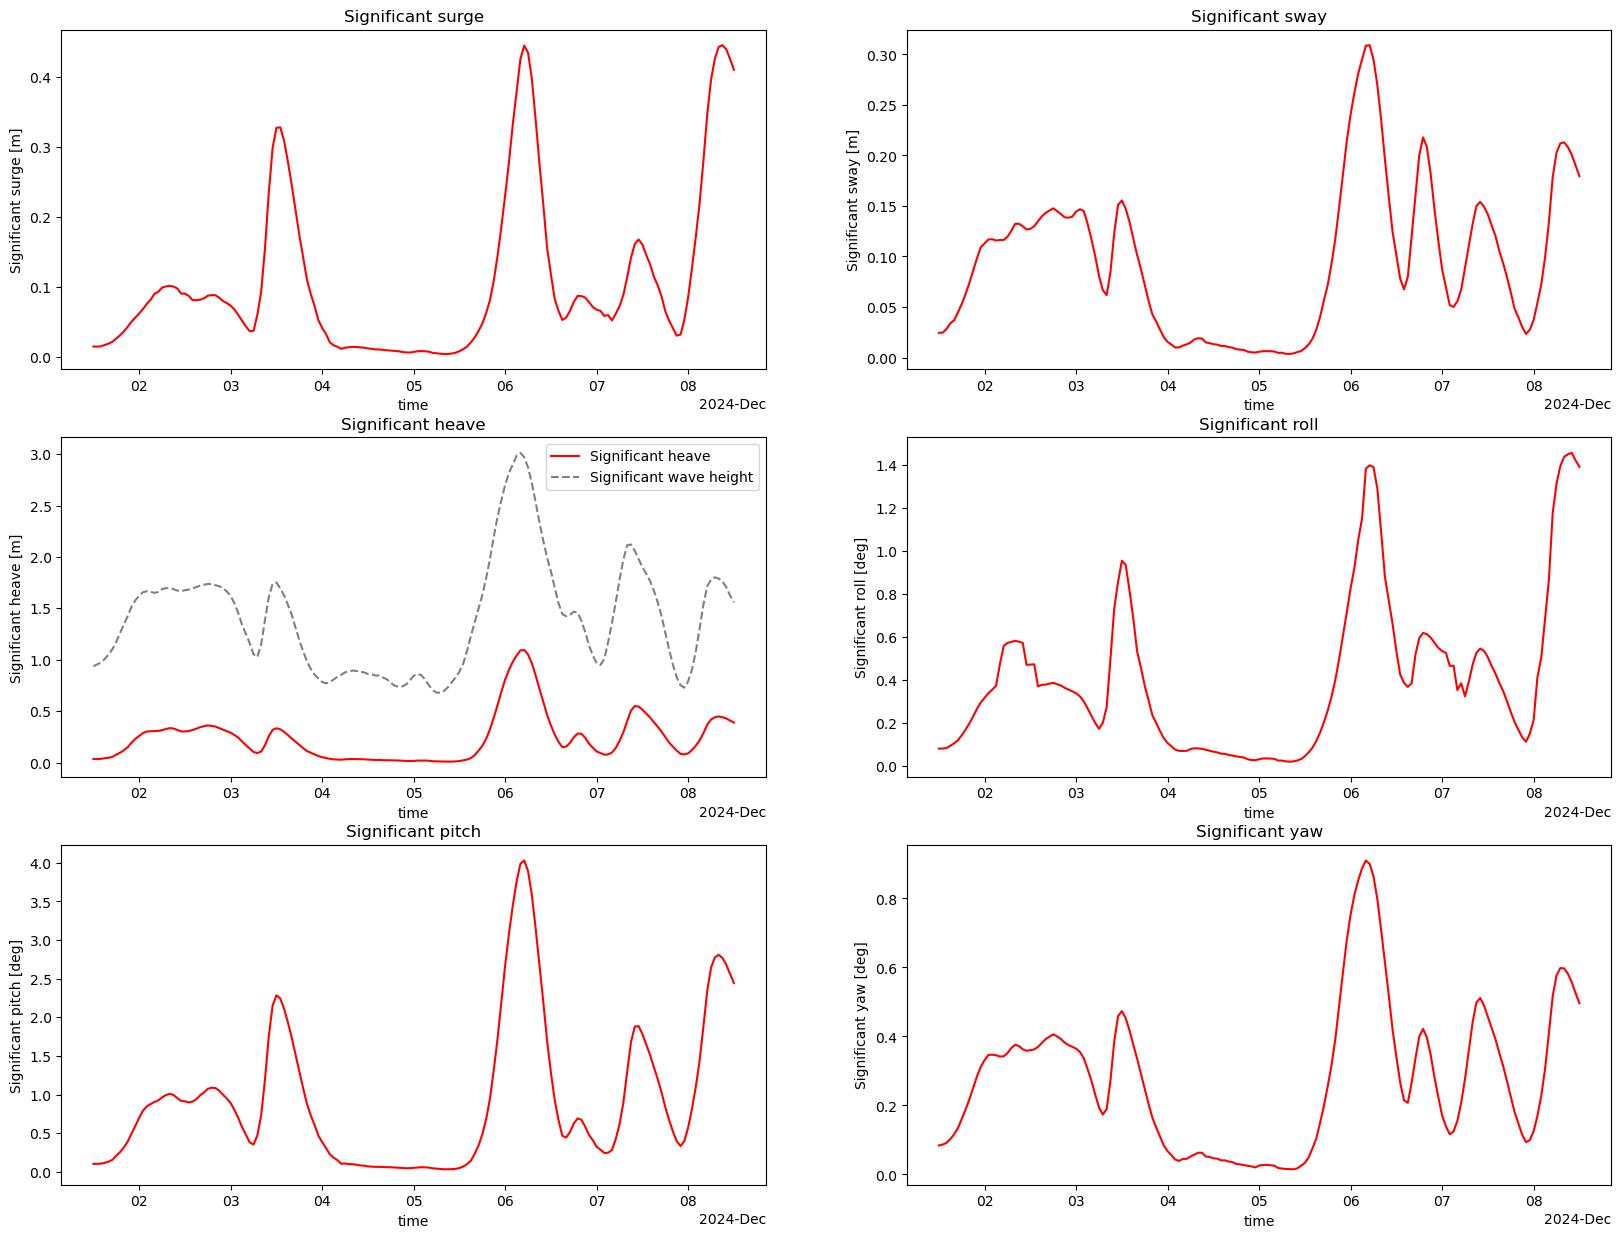

In [98]:
fig, ax = plt.subplots(figsize=(20,15), ncols=2, nrows=3)
ax = ax.flatten()
for idof, dof in enumerate(dofs):
    # Motion curve
    ship_motion0.isel(dof=idof).plot(ax=ax[idof], color='red', label='Significant heave')
    # Plot the wave height on the heave plot
    if dof in ['heave']:
        wave_data.spec.hs().plot(ax=ax[idof], color='grey', linestyle='--', label='Significant wave height')
        ax[idof].legend()

    units = 'm' if idof < 3 else 'deg'
    ax[idof].set_ylabel(f"Significant {dof} [{units}]")
    ax[idof].set_title(f"Significant {dof}")

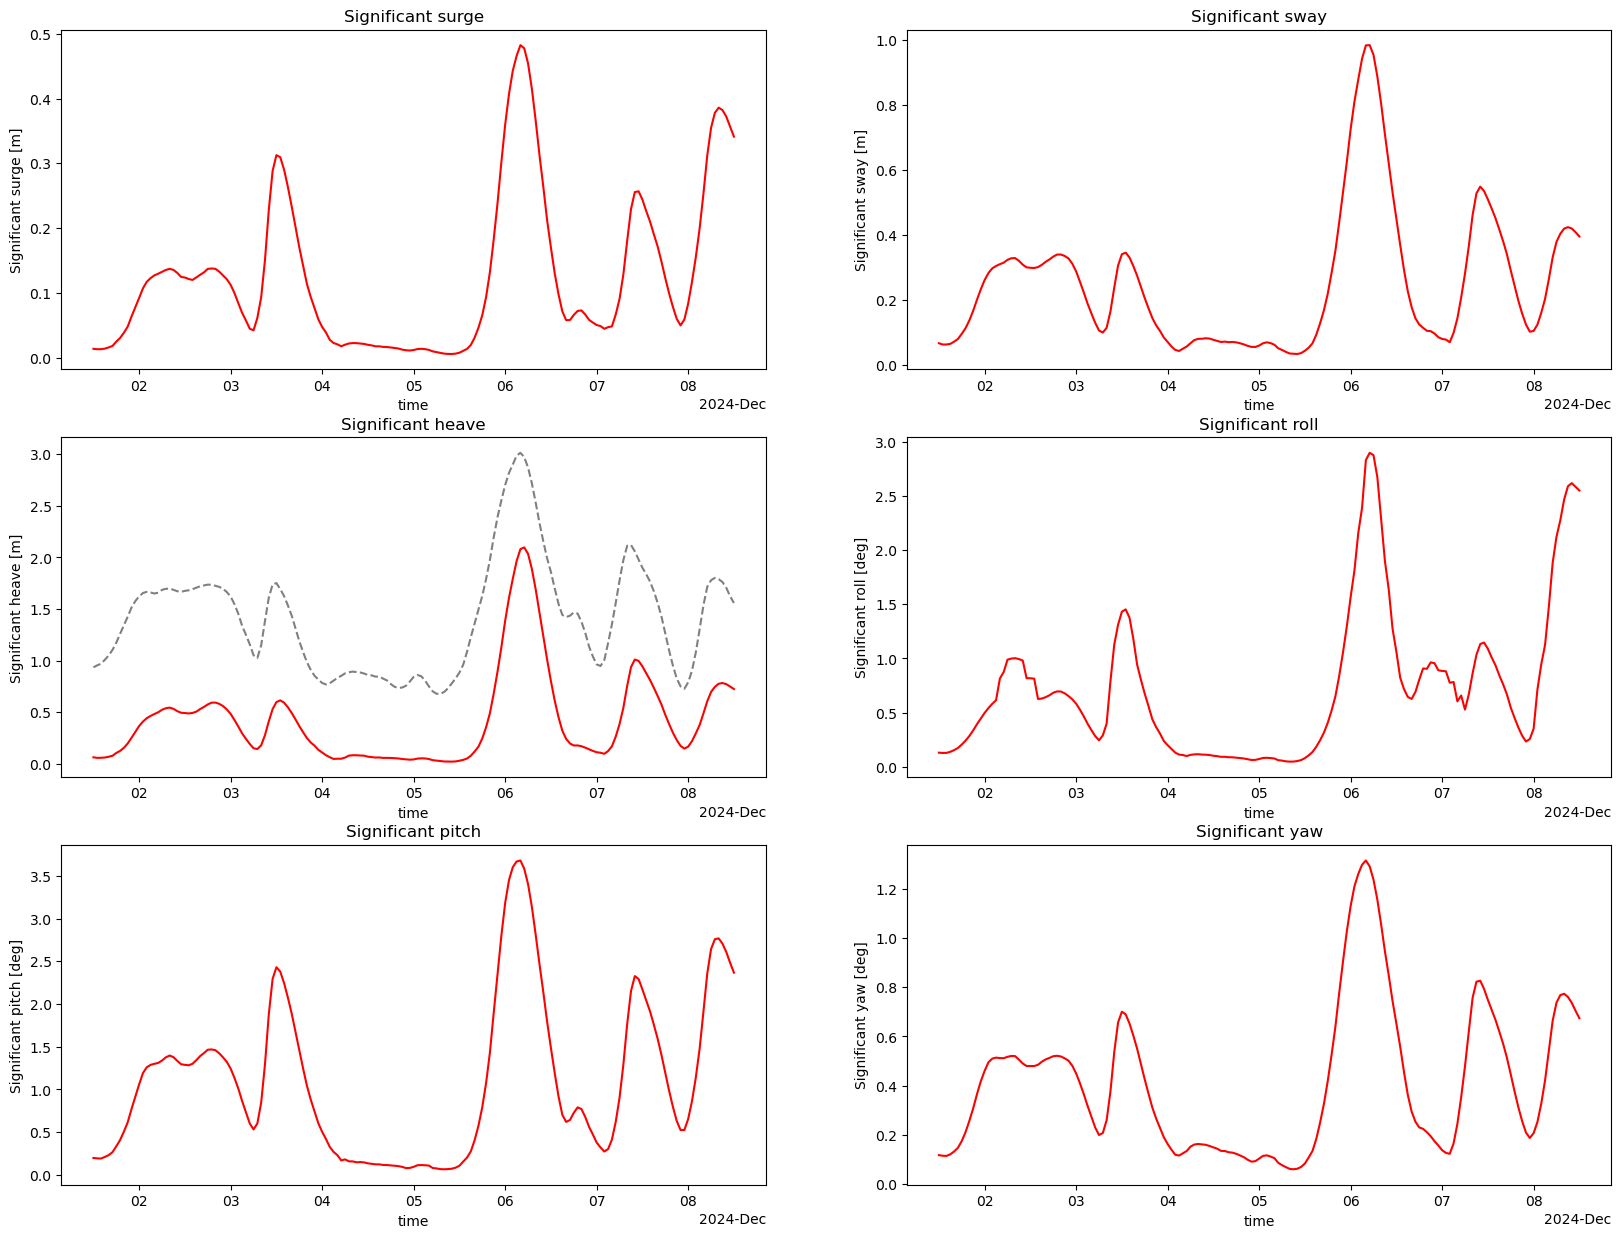

In [97]:
fig, ax = plt.subplots(figsize=(20,15), ncols=2, nrows=3)
ax = ax.flatten()
for idof, dof in enumerate(dofs):
    # Motion curve
    ship_motion90.isel(dof=idof).plot(ax=ax[idof], color='red', label='Significant heave')
    # Plot the wave height on the heave plot
    if dof in ['heave']:
        wave_data.spec.hs().plot(ax=ax[idof], color='grey', linestyle='--', label='Significant wave height')

    units = 'm' if idof < 3 else 'deg'
    ax[idof].set_ylabel(f"Significant {dof} [{units}]")
    ax[idof].set_title(f"Significant {dof}")